In [19]:
import pandas as pd
import plotly.express as px

columns = [
        'join_id','dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        ,'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
        ,'l1_gas_used_on_l2','calldata_bytes_l2_per_day','l2_gas_used','l2_eth_fees_per_day'
        ]

In [20]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515_dt2023_09_08.csv') #https://dune.com/queries/2453515 --last 90 days
goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn_dt2023_09_08.csv') #requires auth - https://dash.goldsky.com/question/9-op-chains-activity-by-period

In [21]:
# Map Chain Names
chain_mappings = {
    'zora': 'Zora Network',
    'pgn': 'Public Goods Network',
    # Add more mappings as needed
}
goldskydf['chain'] = goldskydf['chain'].replace(chain_mappings)

In [22]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
#Generate Join ID Column
dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.merge(goldskydf, on='join_id', how='left')

# display(combo_df)

for c in columns:
        try:
                combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
        except:
                combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']
combo_df['dt_rank'] = combo_df['dt'].rank(method='dense', ascending=False).astype('int')

In [23]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_txs_per_day,l2_num_attr_deposit_txs_per_day,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
24,2023-09-01op mainnet,2023-09-01 00:00:00+00:00,OP Mainnet,86400.0,662,24,76582705.0,17.907715,17.845443,1.776221e+01,...,342105.0,43200.0,326.0,1.865555e+09,157754989.0,1.259217e+11,32.035408,0.662352,0.485453,7
92,2023-08-15op mainnet,2023-08-15 00:00:00+00:00,OP Mainnet,86400.0,2213,24,260678325.0,26.866634,24.612099,2.705905e+01,...,894051.0,43200.0,469.0,6.483200e+09,547778795.0,2.134743e+11,168.087479,0.648497,0.475882,24
26,2023-09-01zora network,2023-09-01 00:00:00+00:00,Zora Network,86400.0,146,24,11317117.0,17.202076,17.269936,1.006200e+10,...,74141.0,43200.0,8.0,2.719527e+08,27745964.0,6.195040e+10,8.870322,0.675113,0.407883,7
277,2023-06-27zora network,2023-06-27 00:00:00+00:00,Zora Network,86400.0,144,24,2653638.0,17.544401,16.380960,2.083924e+09,...,7014.0,43200.0,0.0,2.566269e+07,12782373.0,4.491470e+10,2.171213,1.768169,0.207601,73
25,2023-09-01base,2023-09-01 00:00:00+00:00,Base,86400.0,1429,24,57447825.0,18.212658,18.280392,1.813989e+01,...,346144.0,43200.0,1068.0,1.426713e+09,107816020.0,2.215220e+11,53.524267,0.663383,0.532832,7


In [24]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_on_l2'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 63.0%
Blended bytes compression ratio: 44.0%


In [25]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'gas_compression_ratio',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'bytes_compression_ratio',
                 color='chain',
                 title='Calldata Bytese on each Layer by chain')

fig_bytes.show()

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_txs_per_day,l2_num_attr_deposit_txs_per_day,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
0,2023-09-07op mainnet,2023-09-07 00:00:00+00:00,OP Mainnet,86400.0,614,24,70967575.0,17.876005,17.564603,1.763472e+01,...,354349.0,43200.0,449.0,1.797814e+09,149355858.0,1.373005e+11,31.358216,0.636979,0.475158,1
1,2023-09-07base,2023-09-07 00:00:00+00:00,Base,86400.0,1431,24,56170604.0,18.223106,17.189830,1.809397e+01,...,325736.0,43200.0,760.0,1.417440e+09,110999142.0,2.211692e+11,32.802708,0.653330,0.506045,1
2,2023-09-07zora network,2023-09-07 00:00:00+00:00,Zora Network,86400.0,183,24,13738192.0,17.591169,18.234762,1.133676e+10,...,96359.0,43200.0,26.0,3.326724e+08,29555694.0,6.944849e+10,11.796937,0.670250,0.464824,1
4,2023-09-06op mainnet,2023-09-06 00:00:00+00:00,OP Mainnet,86400.0,616,24,71236352.0,19.110582,18.172530,1.885265e+01,...,352441.0,43200.0,361.0,1.827877e+09,152566694.0,1.455955e+11,33.899695,0.628893,0.466919,2
5,2023-09-06base,2023-09-06 00:00:00+00:00,Base,86400.0,1424,24,57450098.0,19.107476,17.935865,1.899765e+01,...,332740.0,43200.0,577.0,1.453732e+09,113272698.0,2.212035e+11,32.901866,0.650960,0.507184,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2023-06-14op mainnet,2023-06-14 00:00:00+00:00,OP Mainnet,86400.0,846,24,93347122.0,22.388467,20.089097,2.182302e+01,...,535146.0,43200.0,481.0,2.523803e+09,201883259.0,1.965987e+11,55.608184,0.597109,0.462382,86
316,2023-06-13op mainnet,2023-06-13 00:00:00+00:00,OP Mainnet,86400.0,783,24,85583465.0,17.184042,16.949245,1.703237e+01,...,456496.0,43200.0,430.0,2.251531e+09,187008884.0,1.736718e+11,33.476594,0.613762,0.457644,87
318,2023-06-12op mainnet,2023-06-12 00:00:00+00:00,OP Mainnet,86400.0,753,24,81822522.0,17.964138,17.094217,1.779595e+01,...,418992.0,43200.0,470.0,2.173674e+09,186071777.0,1.592237e+11,31.749409,0.607850,0.439736,88
319,2023-06-11op mainnet,2023-06-11 00:00:00+00:00,OP Mainnet,86400.0,698,24,75076007.0,17.448444,16.546322,1.713917e+01,...,386861.0,43200.0,446.0,2.022271e+09,176495625.0,1.470628e+11,29.800585,0.599574,0.425370,89


In [26]:
df = combo_df[combo_df['active_secs_per_day']==86400].copy()
display(df.sample(5))

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_txs_per_day,l2_num_attr_deposit_txs_per_day,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
24,2023-09-01op mainnet,2023-09-01 00:00:00+00:00,OP Mainnet,86400.0,662,24,76582705.0,17.907715,17.845443,1.776221e+01,...,342105.0,43200.0,326.0,1.865555e+09,157754989.0,1.259217e+11,32.035408,0.662352,0.485453,7
207,2023-07-18public goods network,2023-07-18 00:00:00+00:00,Public Goods Network,86400.0,146,24,1863638.0,29.720391,28.346003,3.075120e+06,...,4.0,43200.0,2.0,1.207200e+04,11233356.0,4.320159e+10,0.001220,2719.672631,0.165902,52
98,2023-08-14zora network,2023-08-14 00:00:00+00:00,Zora Network,86400.0,156,24,12091978.0,21.221870,21.396446,1.480522e+10,...,102392.0,43200.0,13.0,2.985427e+08,24788764.0,5.826737e+10,8.786903,0.656950,0.487801,25
303,2023-06-18base,2023-06-18 00:00:00+00:00,Base,86400.0,1432,24,2046297.0,15.291874,15.056151,NaN,...,0.0,43200.0,0.0,NaN,11232000.0,2.168383e+09,0.000000,NaN,0.182185,82
114,2023-08-10zora network,2023-08-10 00:00:00+00:00,Zora Network,86400.0,146,24,6050032.0,21.960891,21.158316,8.349240e+09,...,29667.0,43200.0,7.0,1.267450e+08,21221647.0,5.180086e+10,5.606701,0.785874,0.285088,29


In [27]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Selecting the features and target variable
features = ['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day','l2_num_user_deposit_txs_per_day','l2_num_attr_deposit_txs_per_day']
target = 'l1_gas_used_inbox'

# Drop rows with missing values for now
df_cleaned = df.dropna(subset=features + [target])

# Splitting the data into training and testing sets (80% train, 20% test)
X = df_cleaned[features]
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((246, 4), (62, 4))

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2

(27372464.30356123, 1754736428310717.8, 0.9966963467175538)

In [29]:
# Retrieve the coefficients and intercept of the model
coefficients = model.coef_
intercept = model.intercept_

coefficients, intercept


(array([ 1.20171084e+00, -4.73524537e+00, -1.21058188e+03, -1.19818444e+04]),
 96127538.9795456)

```
r^2 = .9962

l1_gas_used_inbox =
          0.6543×l1_gas_used_on_l2
        − 0.4929×calldata_bytes_l2_per_day
        − 159.8580×l2_num_txs_per_day
        + 40,193,003.72
```
        

In [30]:
# test other features

# Identify columns that do not include 'l1' and 'compression_ratio', except for the one already identified
potential_features = [col for col in df.columns if 'l1' not in col and 'compression_ratio' not in col]
potential_features.append('l1_gas_used_on_l2')  # add the already identified feature

# Remove the non-feature columns (like identifiers and target)
non_feature_columns = ['Unnamed: 0', 'join_id', 'dt', 'chain']
potential_features = [col for col in potential_features if col not in non_feature_columns]

potential_features



['active_secs_per_day',
 'l2_contrib_l2_eth_fees_per_day',
 'l2_num_txs_per_day',
 'l2_num_attr_deposit_txs_per_day',
 'l2_num_user_deposit_txs_per_day',
 'calldata_bytes_l2_per_day',
 'l2_gas_used',
 'l2_eth_fees_per_day',
 'dt_rank',
 'l1_gas_used_on_l2']

In [31]:
# Re-preprocess the data considering all potential features
df_cleaned_all = df.dropna(subset=potential_features + [target])

# Splitting the data again
X_all = df_cleaned_all[potential_features]
y_all = df_cleaned_all[target]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Updated function to evaluate features using the new datasets
def evaluate_features_updated(features_list):
    X_train_subset = X_train_all[features_list]
    X_test_subset = X_test_all[features_list]

    # Train the model
    model = LinearRegression()
    model.fit(X_train_subset, y_train_all)

    # Predict and evaluate
    y_pred = model.predict(X_test_subset)
    r2 = r2_score(y_test_all, y_pred)
    return r2

# Re-evaluate models
original_r2_updated = evaluate_features_updated(['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day','l2_num_user_deposit_txs_per_day'])
all_features_r2_updated = evaluate_features_updated(potential_features)

# Removing one feature at a time from the full set
drop_one_r2_updated = {}
for feature in potential_features:
    subset = [f for f in potential_features if f != feature]
    r2 = evaluate_features_updated(subset)
    drop_one_r2_updated[feature] = r2

print(original_r2_updated, all_features_r2_updated, drop_one_r2_updated)
print('this shows that our original model was "best"')

0.9966963467175538 0.9969069811109506 {'active_secs_per_day': 0.9969069810573787, 'l2_contrib_l2_eth_fees_per_day': 0.9968483448812926, 'l2_num_txs_per_day': 0.9955852403671834, 'l2_num_attr_deposit_txs_per_day': 0.9969069811130433, 'l2_num_user_deposit_txs_per_day': 0.996907503702946, 'calldata_bytes_l2_per_day': 0.9952678252635068, 'l2_gas_used': 0.9975234499113806, 'l2_eth_fees_per_day': 0.9963300793603539, 'dt_rank': 0.9969304529178015, 'l1_gas_used_on_l2': 0.9902825182110927}
this shows that our original model was "best"


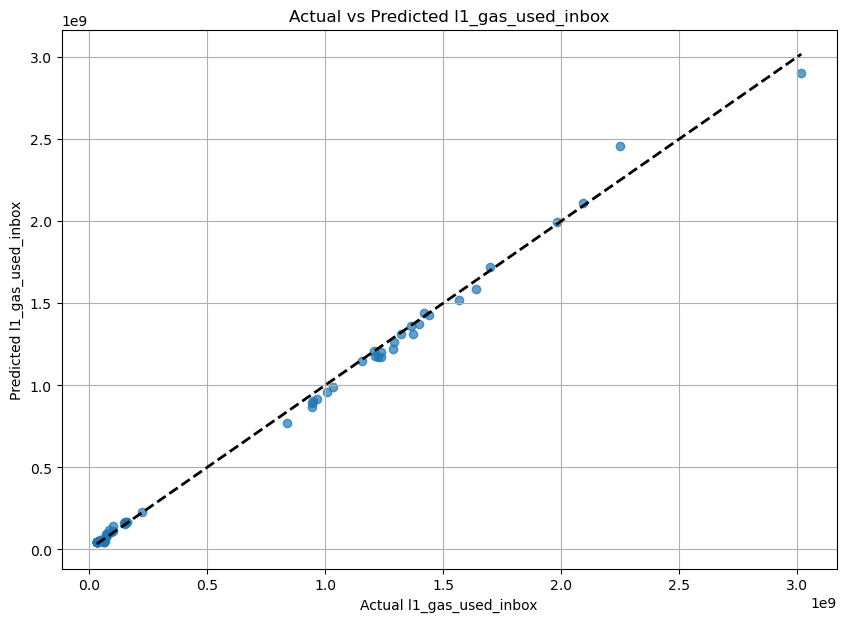

In [32]:
# Train the best model on the original set of features
best_features = ['l1_gas_used_on_l2', 'calldata_bytes_l2_per_day', 'l2_num_txs_per_day']
X_train_best = X_train_all[best_features]
X_test_best = X_test_all[best_features]

best_model = LinearRegression()
best_model.fit(X_train_best, y_train_all)

# Retrieve the coefficients and intercept of the best model
best_coefficients = best_model.coef_
best_intercept = best_model.intercept_

best_coefficients, best_intercept

import matplotlib.pyplot as plt

# Predict with the best model
y_pred_best = best_model.predict(X_test_best)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 7))
plt.scatter(y_test_all, y_pred_best, alpha=0.7)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'k--', lw=2)
plt.xlabel('Actual l1_gas_used_inbox')
plt.ylabel('Predicted l1_gas_used_inbox')
plt.title('Actual vs Predicted l1_gas_used_inbox')
plt.grid(True)
plt.show()


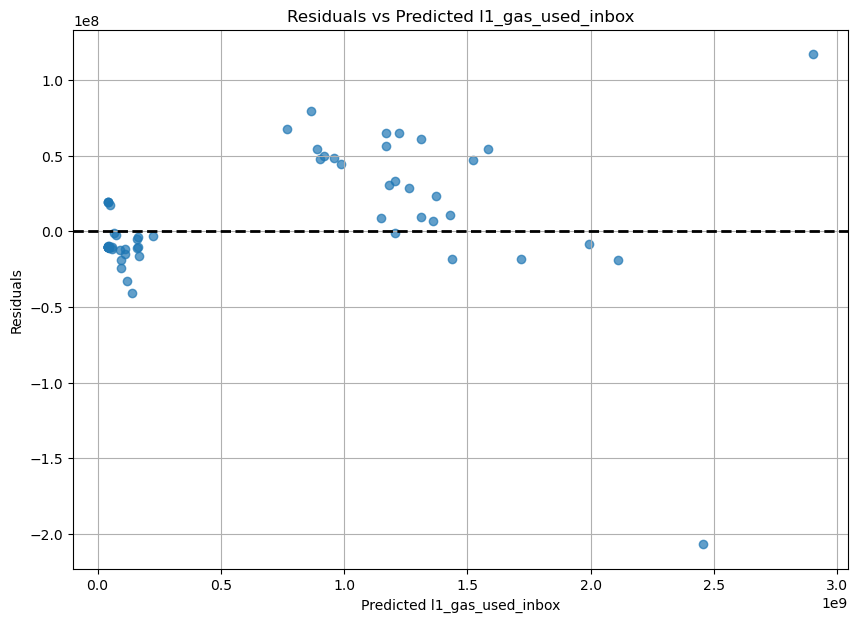

In [33]:
# Test Polynomial Model

# Calculate residuals
residuals = y_test_all - y_pred_best

# Plotting residuals against predicted values
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted l1_gas_used_inbox')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted l1_gas_used_inbox')
plt.grid(True)
plt.show()


In [34]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_best)
X_test_poly = poly_transformer.transform(X_test_best)

# Train the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_all)

# Predict and evaluate
y_pred_poly = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test_all, y_pred_poly)
mae_poly = mean_absolute_error(y_test_all, y_pred_poly)
mse_poly = mean_squared_error(y_test_all, y_pred_poly)

r2_poly, mae_poly, mse_poly


(0.9978157924990029, 23609317.47659536, 1160142466933241.0)

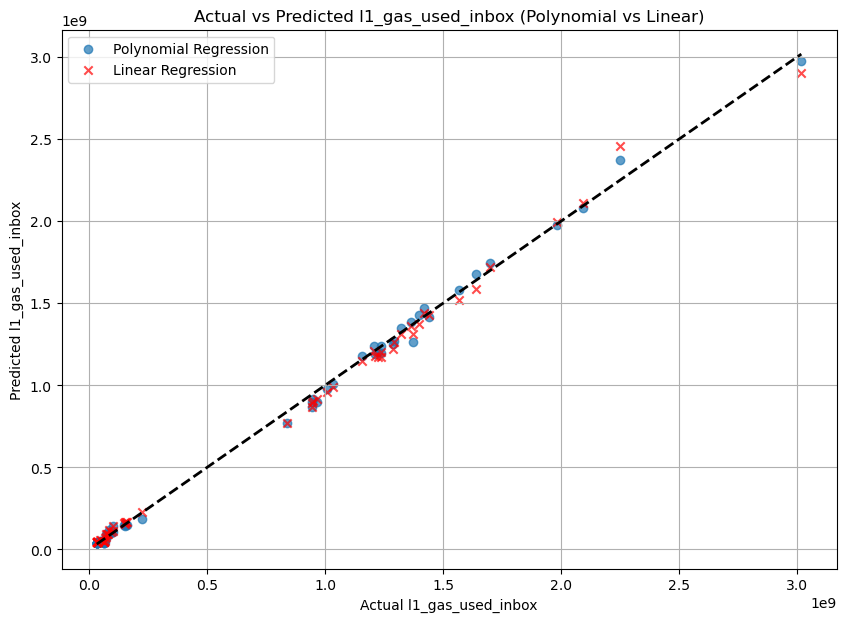

In [35]:
# Plotting actual vs predicted values for the polynomial regression model
plt.figure(figsize=(10, 7))
plt.scatter(y_test_all, y_pred_poly, alpha=0.7, label='Polynomial Regression')
plt.scatter(y_test_all, y_pred_best, alpha=0.7, color='red', marker='x', label='Linear Regression')
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'k--', lw=2)
plt.xlabel('Actual l1_gas_used_inbox')
plt.ylabel('Predicted l1_gas_used_inbox')
plt.title('Actual vs Predicted l1_gas_used_inbox (Polynomial vs Linear)')
plt.legend()
plt.grid(True)
plt.show()


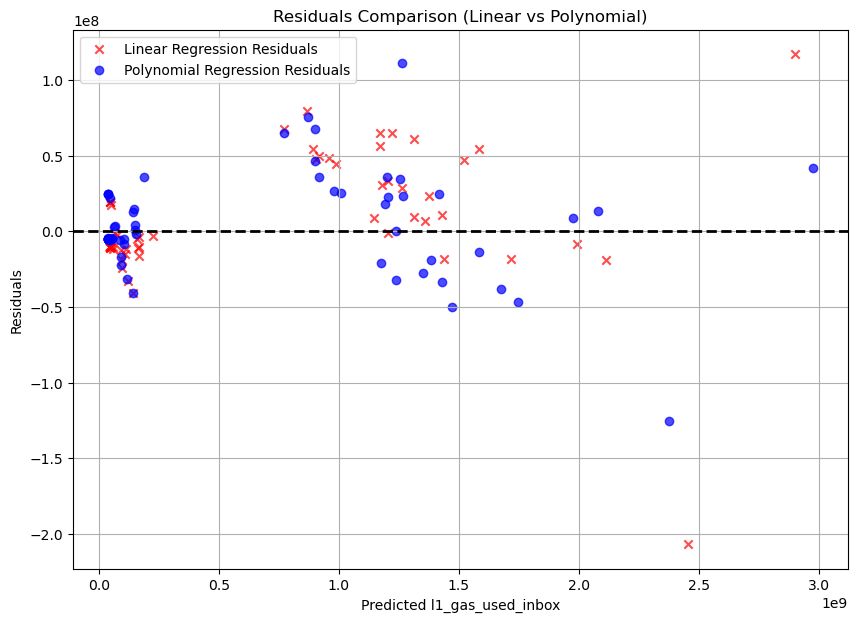

AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

In [36]:
# Calculate residuals for the polynomial model
residuals_poly = y_test_all - y_pred_poly

# Plotting residuals comparison
plt.figure(figsize=(10, 7))
plt.scatter(y_pred_best, residuals, alpha=0.7, color='red', marker='x', label='Linear Regression Residuals')
plt.scatter(y_pred_poly, residuals_poly, alpha=0.7, color='blue', label='Polynomial Regression Residuals')
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted l1_gas_used_inbox')
plt.ylabel('Residuals')
plt.title('Residuals Comparison (Linear vs Polynomial)')
plt.legend()
plt.grid(True)
plt.show()

# Retrieve the coefficients from the polynomial model
poly_coefficients = poly_model.coef_
poly_intercept = poly_model.intercept_

# Mapping feature names to their polynomial terms
feature_names = poly_transformer.get_feature_names(input_features=best_features)

poly_equation = f"l1_gas_used_inbox = {poly_intercept:.2f}"
for coef, feature in zip(poly_coefficients, feature_names):
    poly_equation += f" + {coef:.2f}*{feature}"

poly_equation


#### Linear Model
$$
\begin{align*}
\text{l1\_gas\_used\_inbox} &= 40,193,003.72 \\
&+ 0.6543 \times \text{l1\_gas\_used\_on\_l2} \\
&- 0.4929 \times \text{calldata\_bytes\_l2\_per\_day} \\
&- 159.8580 \times \text{l2\_num\_txs\_per\_day} \\
R^2 &= 0.9962 \\
\end{align*}


#### Polynomial Model
$$
\begin{align*}
\text{l1\_gas\_used\_inbox} &= -88,399,846.41 \\
&- 1.03 \times \text{l1\_gas\_used\_on\_l2} \\
&+ 13.77 \times \text{calldata\_bytes\_l2\_per\_day} \\
&+ 2824.17 \times \text{l2\_num\_txs\_per\_day} \\
&- 0.00 \times \text{l1\_gas\_used\_on\_l2}^2 \\
&+ 0.00 \times \text{l1\_gas\_used\_on\_l2} \times \text{calldata\_bytes\_l2\_per\_day} \\
&+ 0.00 \times \text{l1\_gas\_used\_on\_l2} \times \text{l2\_num\_txs\_per\_day} \\
&- 0.00 \times \text{calldata\_bytes\_l2\_per\_day}^2 \\
&- 0.00 \times \text{calldata\_bytes\_l2\_per\_day} \times \text{l2\_num\_txs\_per\_day} \\
&- 0.01 \times \text{l2\_num\_txs\_per\_day}^2 \\
R^2 &= 0.9974 \\
\end{align*}


Linear model is much simpler, so let's just use that. It breaks down a bit at larger gas used environments, so we'll refine as we have more days like that.

Note: This only applies to the standard OP Chain config. We have a more detailed projection model for changed configs, but note that the config change model is way more involved and potentially inaccurate